# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Explaining-Decision-Trees-and-Random-Forests" data-toc-modified-id="Explaining-Decision-Trees-and-Random-Forests-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Explaining Decision Trees and Random Forests</a></div><div class="lev1 toc-item"><a href="#Import-Libraries" data-toc-modified-id="Import-Libraries-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Import Libraries</a></div><div class="lev1 toc-item"><a href="#Load-Data" data-toc-modified-id="Load-Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load Data</a></div><div class="lev1 toc-item"><a href="#Build-Model" data-toc-modified-id="Build-Model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Build Model</a></div><div class="lev2 toc-item"><a href="#Create-Feature-Contribution" data-toc-modified-id="Create-Feature-Contribution-41"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Create Feature Contribution</a></div><div class="lev1 toc-item"><a href="#Visualizing-Decision-Trees" data-toc-modified-id="Visualizing-Decision-Trees-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Visualizing Decision Trees</a></div><div class="lev1 toc-item"><a href="#Plot-Feature-Importances" data-toc-modified-id="Plot-Feature-Importances-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Plot Feature Importances</a></div><div class="lev1 toc-item"><a href="#Plot-Feature-Contributions" data-toc-modified-id="Plot-Feature-Contributions-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Plot Feature Contributions</a></div><div class="lev1 toc-item"><a href="#Plotting-Individual-Features" data-toc-modified-id="Plotting-Individual-Features-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Plotting Individual Features</a></div>

# Explaining Decision Trees and Random Forests

This notebook shows examples of how the `treeinterpreter` (<a href='https://github.com/andosa/treeinterpreter'>https://github.com/andosa/treeinterpreter</a>) library works and provides some insightful plots to gain a deeper understanding of what a decision tree or random forest is doing.

I have created a set of useful plotting functions in the file `tree_interp_functions.py`.

# Import Libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor,\
                         export_graphviz
from treeinterpreter import treeinterpreter as ti
import pydotplus
from IPython.display import Image, display

from tree_interp_functions import *

In [2]:
# Set default matplotlib settings
plt.rcParams['figure.figsize'] = (10, 7)
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['figure.titlesize'] = 26
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 16

# Set seaborn colours
blue, green, red, purple, yellow, cyan = sns.color_palette()

# Load Data
We will use the abalone data set as an example. We would like to show how this works for decision tree and random forest regressors as well as classifiers. We use the `rings` variable as our continuous variable and create a binary variable from it to indicate whether `rings > 9`.

In [3]:
column_names = ["sex", "length", "diameter", "height", "whole weight", 
                "shucked weight", "viscera weight", "shell weight", "rings"]
abalone_df = pd.read_csv('abalone.csv', names=column_names)
abalone_df['sex'] = abalone_df['sex'].map({'F': 0, 'I': 1, 'M': 2})
abalone_df['y'] = abalone_df.rings.map(lambda x: 1 if x > 9 else 0)
abalone_df.head()

,sex,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight,rings,y
0,2,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,1
1,2,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,0
2,0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,0
3,2,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,1
4,1,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,0


Here, we do a simple train/test split of the data.

In [4]:
abalone_train, abalone_test = train_test_split(abalone_df, test_size=0.2,
                                               random_state=0)

X_train = abalone_train.iloc[:, :-2]
y_train = abalone_train.y

X_test = abalone_test.iloc[:, :-2]
y_test = abalone_test.y

X_train = X_train.copy().reset_index(drop=True)
y_train = y_train.copy().reset_index(drop=True)
X_test = X_test.copy().reset_index(drop=True)
y_test = y_test.copy().reset_index(drop=True)

# Build Model
Now, we build simple decision tree and random forest models. We will limit the depth of the decision tree to show how the interpretation works.

In [5]:
dt_clf = DecisionTreeClassifier(criterion='entropy', max_depth=3,
                                random_state=0)
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')

In [6]:
rf_clf = RandomForestClassifier(criterion='entropy', max_depth=10,
                                n_estimators=100, random_state=0)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

## Create Feature Contribution
We use the `ti.predict` function to get our predictions, biases, and contributions. The contributions matrix is a 3d array which represents the contribution for each example, feature, and class label.

In [7]:
dt_pred, dt_bias, dt_contrib = ti.predict(dt_clf, X_test)
rf_pred, rf_bias, rf_contrib = ti.predict(rf_clf, X_test)

# Create DataFrame containing contributions
dt_contrib_df = pd.DataFrame(dt_contrib[:, :, 1], columns=X_test.columns)
rf_contrib_df = pd.DataFrame(rf_contrib[:, :, 1], columns=X_test.columns)

# Visualizing Decision Trees
We can visualize a decision tree by using graphviz. This will show every path down to the leaves and the proportion of the two classes in each node.

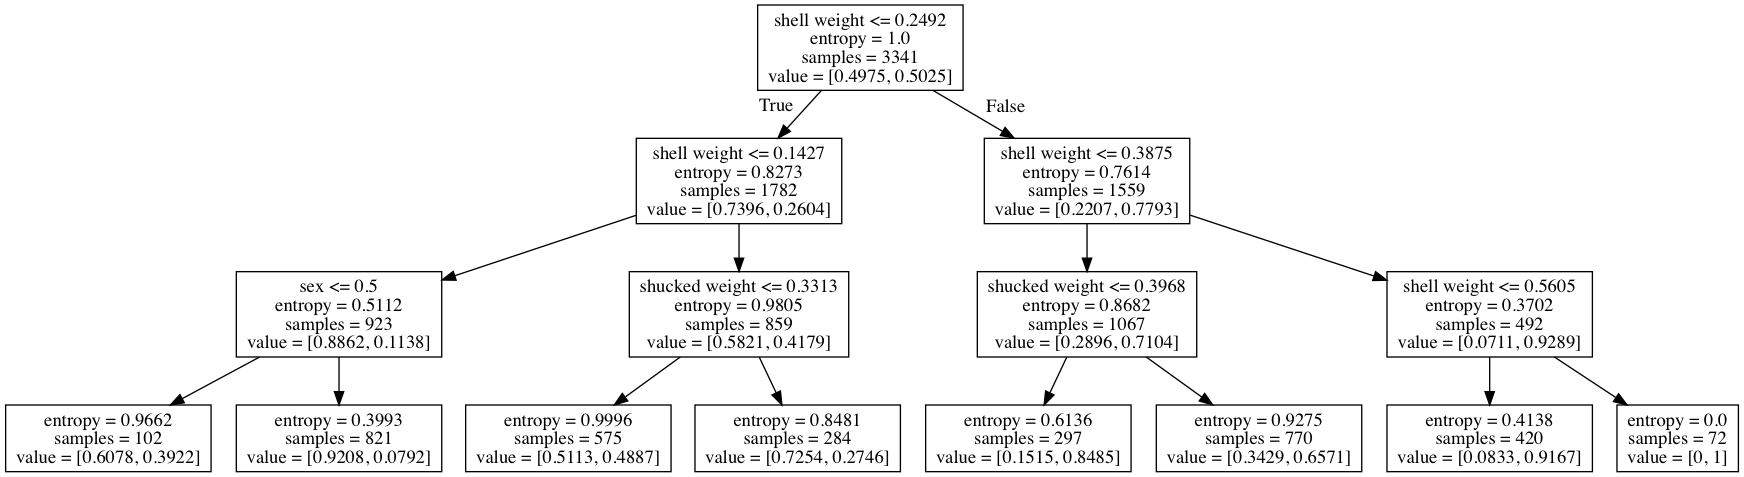

In [8]:
dot_data = export_graphviz(dt_clf,
                           out_file=None,
                           feature_names=X_train.columns
                          )
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

# Plot Feature Importances
One of the more standard ways of understanding decision trees/random forests is to use feature importance. This is built into sklearn.

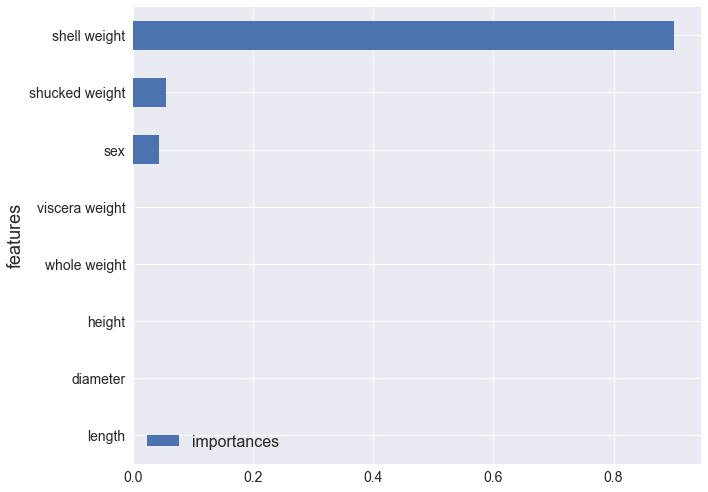

In [9]:
df_importances = pd.DataFrame({'features': X_train.columns,
                               'importances': dt_clf.feature_importances_
                              })
df_importances\
    .set_index('features')\
    .sort_values('importances')\
    .plot(kind='barh')
plt.tight_layout()

# Plot Feature Contributions
Feature contributions give us more insight into how each feature affects an observation. It is not a set of value for the entire classifier like feature importances are, but instead varies depending on each example. More specifically, it depends on which leaf/leaves the observation falls into. We show feature contributions for three separate examples.

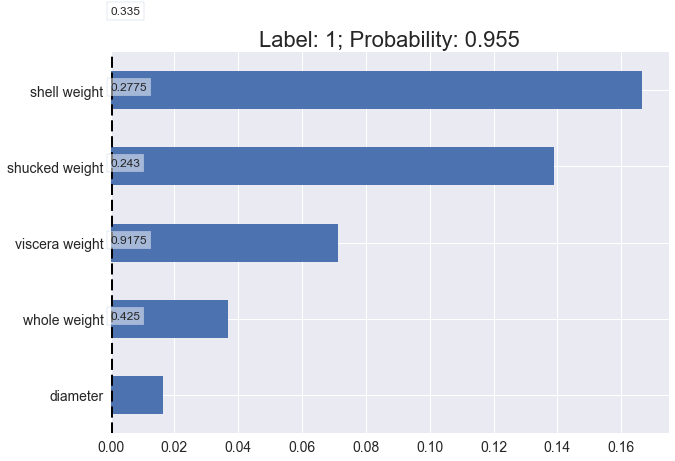

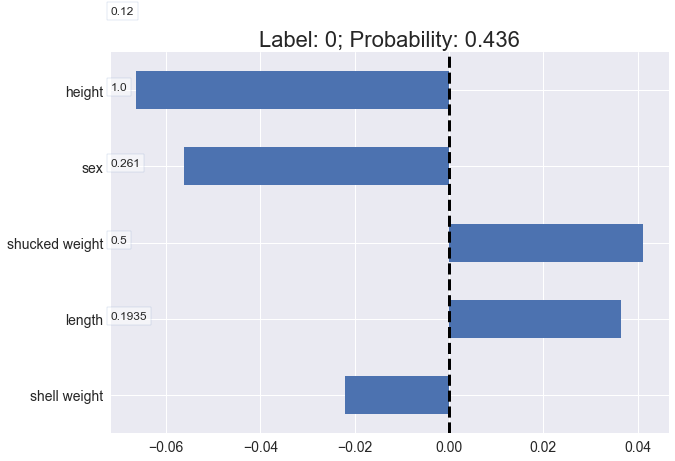

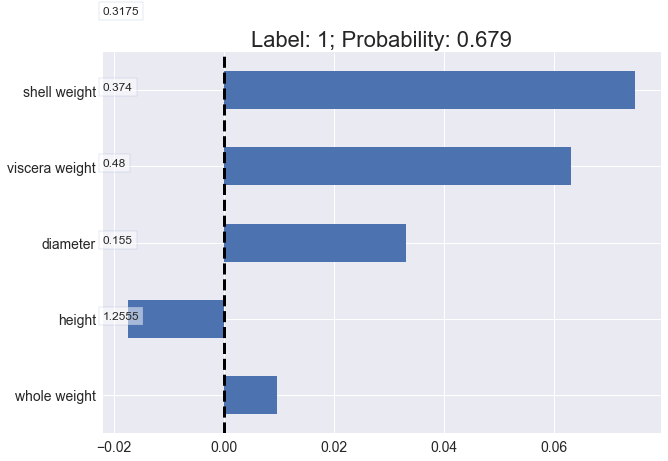

In [10]:
for i in xrange(3):
    _df = plot_top_feat_contrib(rf_clf, rf_contrib_df, X_test, y_test, i,
                                num_features=5,
                                order_by='contribution'
                               )

We can also plot them against the contributions of all observations by using violin plots. This will show the given observation's contributions against the entire population.

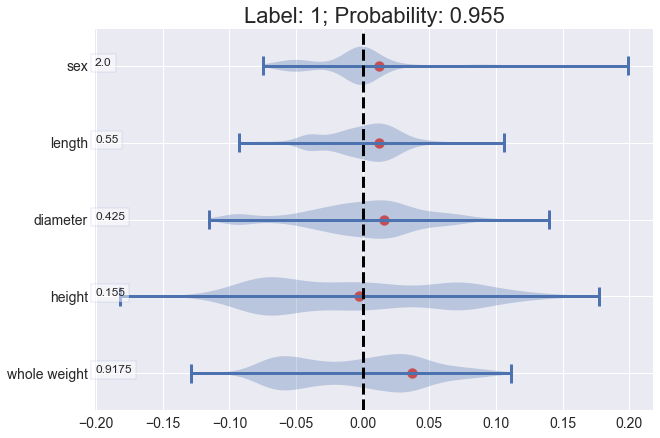

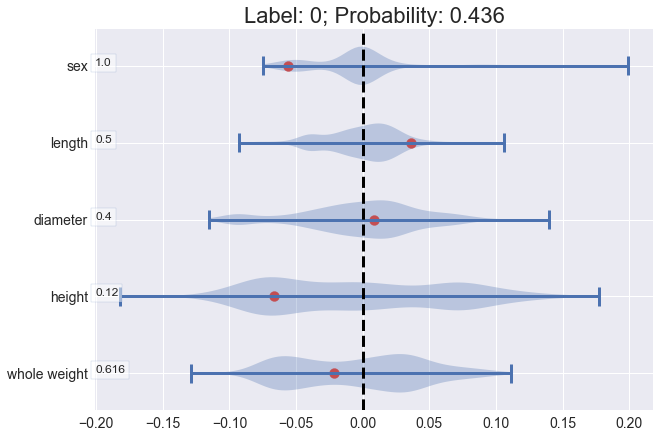

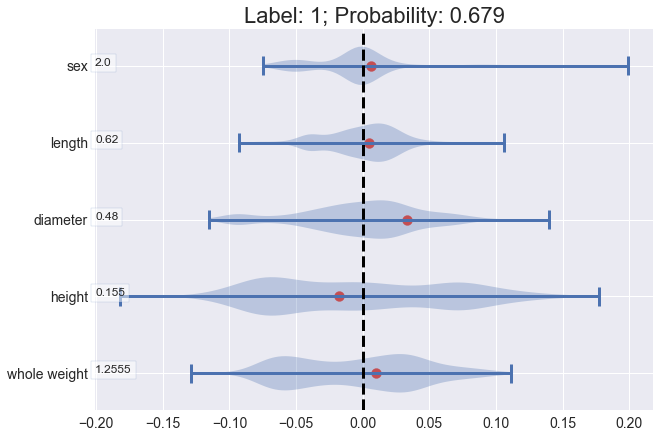

In [11]:
for i in xrange(3):
    _df = plot_top_feat_contrib(rf_clf, rf_contrib_df, X_test, y_test, i,
                                num_features=5,
                                order_by='natural',
                                violin=True
                               )

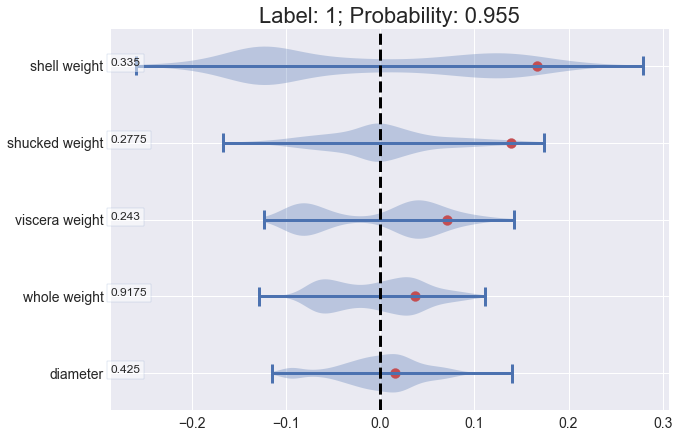

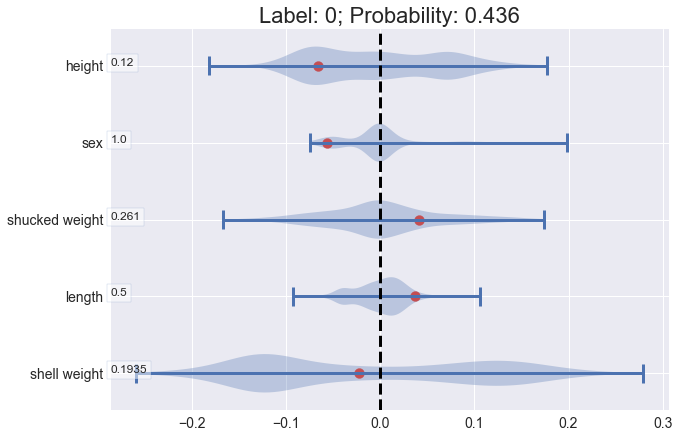

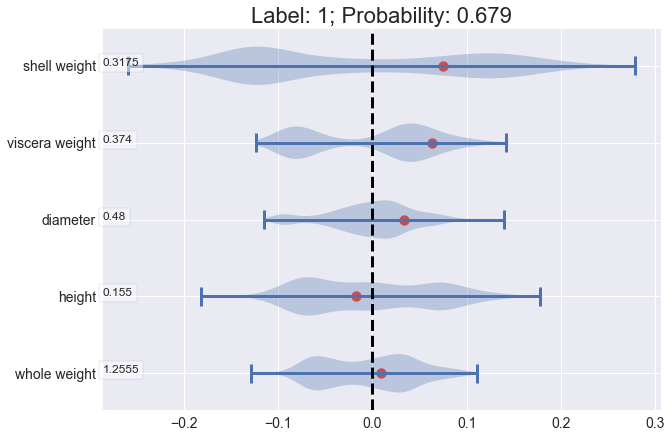

In [12]:
for i in xrange(3):
    _df = plot_top_feat_contrib(rf_clf, rf_contrib_df, X_test, y_test, i,
                                num_features=5,
                                order_by='contribution',
                                violin=True
                               )

# Plotting Individual Features
We now plot individual feature values against their contribution. This should give us some pattern on how each feature affects the contribution of that feature in the model.

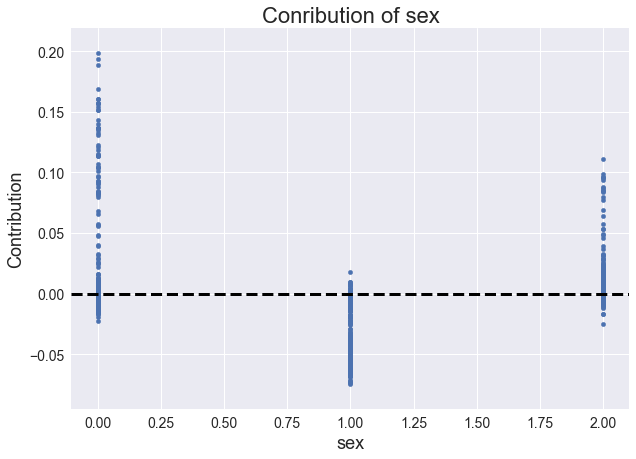

In [13]:
plot_single_feat_contrib('sex', X_test, rf_contrib_df)

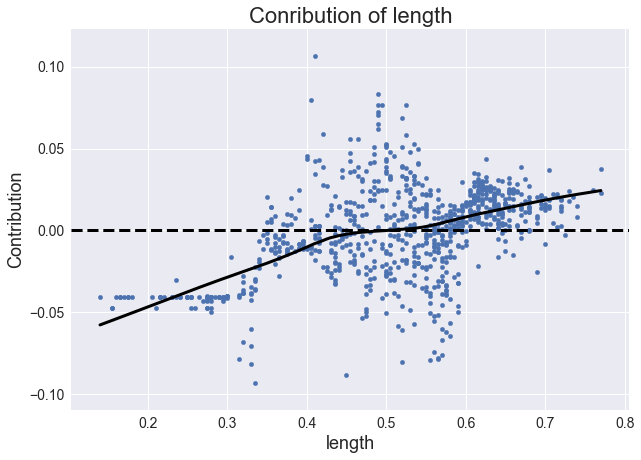

In [14]:
plot_single_feat_contrib('length', X_test, rf_contrib_df, add_smooth=True)

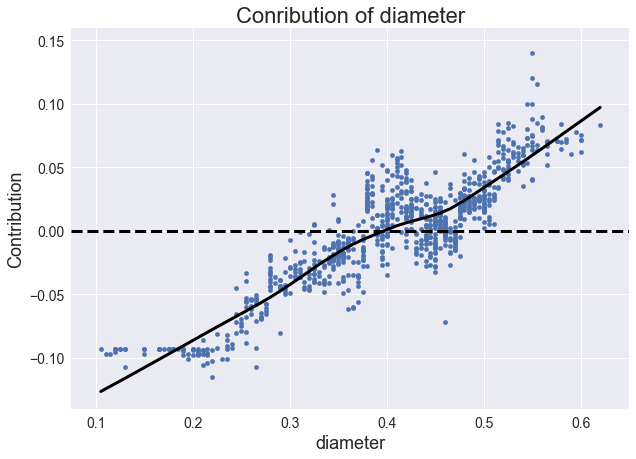

In [15]:
plot_single_feat_contrib('diameter', X_test, rf_contrib_df, add_smooth=True)